### 
Group - 9<br>
Rathlavath Vishal - 24EE10081<br>
Rishabh Sethia - 24EE10082<br>
Rohit Kumar - 24EE10083<br>

## Interpreting the Dataset 

Target attribute - Car acceptibility<br>
Attributes - buying,maint,doors,persons,lug_boot,safety<br>


Number of attributres -  6<br>
Number of instances - 1728<br>

# Meaning of the attibute names <br>
buying - buying price<br>
maint - price of maintenance<br>
doors - number of doors<br> 
persons - capacity in terms of persons to carry<br>
lug_boot - the size of luggage boot<br>
safety - estimated safety of the car<br>

Here we are briefly checking two main attributes with sub inputs<br>
[1]PRICE - Overall price {buying + maint}<br>
[2]TECH - technical comforts<br>
______[2(a)]COMFORT - {doors,persons,lug_boot}<br>
______[2(b)]safety<br>

The model includes three intermediate concepts : PRICE,TECH,COMFORT

### Attribute Values <br>
1. buying - {v-high, high, med, low}<br>
2. maint - {v-high, high, med, low}<br>
3. doors - {2, 3, 4, 5-more}<br>
4. persons - {2, 4, more}<br>
5. lug_boot - {small, med, big}<br>
6. safety - {low, med, high}<br>

Class values : unacc , acc , good , vgood 

# Class Distribution 
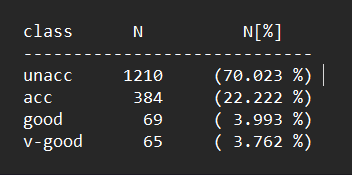

# Preparing the dataset in desired representation

In [2124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random

In [2125]:
file_location = 'car.data'

In [2126]:
def prepare_dataset(file_path):
    df = pd.read_csv(file_path , header = None)
    df.columns = ['buying' , 'maint' , 'doors' , 'persons' , 'lug_boot' , 'safety' , 'car_acceptibility']
    target_attribute = df.columns[-1]
    attributes = list(df.columns[:-1])

    return df , target_attribute , attributes

In [2127]:
car_data , target_car_attribute , all_attributes = prepare_dataset(file_location)
print(car_data)
print("The target attribute which we are trying to learn : ",target_car_attribute)
print("The list of all attributes : ",all_attributes)

     buying  maint  doors persons lug_boot safety car_acceptibility
0     vhigh  vhigh      2       2    small    low             unacc
1     vhigh  vhigh      2       2    small    med             unacc
2     vhigh  vhigh      2       2    small   high             unacc
3     vhigh  vhigh      2       2      med    low             unacc
4     vhigh  vhigh      2       2      med    med             unacc
...     ...    ...    ...     ...      ...    ...               ...
1723    low    low  5more    more      med    med              good
1724    low    low  5more    more      med   high             vgood
1725    low    low  5more    more      big    low             unacc
1726    low    low  5more    more      big    med              good
1727    low    low  5more    more      big   high             vgood

[1728 rows x 7 columns]
The target attribute which we are trying to learn :  car_acceptibility
The list of all attributes :  ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safet

In [2128]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   buying             1728 non-null   object
 1   maint              1728 non-null   object
 2   doors              1728 non-null   object
 3   persons            1728 non-null   object
 4   lug_boot           1728 non-null   object
 5   safety             1728 non-null   object
 6   car_acceptibility  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


# Defining the Impurity_Metric <br>

In the calculation of Entropy we use log2(0) = 0

In [2129]:
def logarithmic(N):
    if(N==0):
        return 0
    else:
        return np.log2(N)

Entropy Calculation<br>
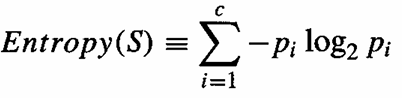

In [2130]:
def entropy(data,targte_attribute):
    class_counts = data[targte_attribute].value_counts()
    total_samples = len(data)
    probabilities = class_counts/total_samples
    entropy = 0
    for p in probabilities : 
        entropy += p*logarithmic(p)
    return -entropy 


Information Gain calculation<br>
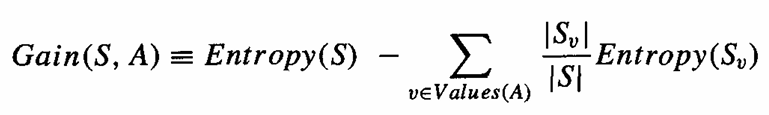

In [2131]:
def information_gain(data, attribute, target):
    parent_entropy = entropy(data, target)
    weighted_entropy = 0.0
    total = len(data)

    for val in data[attribute].unique():
        subset = data[data[attribute] == val]
        prob = len(subset) / total
        weighted_entropy += prob * entropy(subset, target)

    return parent_entropy - weighted_entropy


In [2132]:
def information_gain_all(data, attributes, target_attribute):
    gains = {}
    for attr in attributes:
        gains[attr] = information_gain(data, attr, target_attribute)
    return gains


Gini index calculation<br>
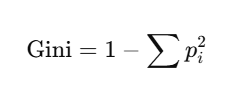

In [2133]:
def gini_node(data, target):
    total = len(data)
    if total == 0:
        return 0

    gini = 1.0
    for cls in data[target].unique():
        p = len(data[data[target] == cls]) / total
        gini -= p ** 2

    return gini


In [2134]:
def gini_index(data, attribute, target):
    total_samples = len(data)
    gini = 0.0

    for value in data[attribute].unique():
        subset = data[data[attribute] == value]
        subset_size = len(subset)

        if subset_size == 0:
            continue

        subset_gini = 1.0
        for cls in subset[target].unique():
            p = len(subset[subset[target] == cls]) / subset_size
            subset_gini -= p ** 2

        gini += (subset_size / total_samples) * subset_gini

    return gini


In [2135]:
def gini_all(data,attribute,target_attribute):
    gini_values=[]
    for j in attribute:
        gini_values.append(gini_node(data,j,target_attribute))
    return gini_values

Gain ratio calculation
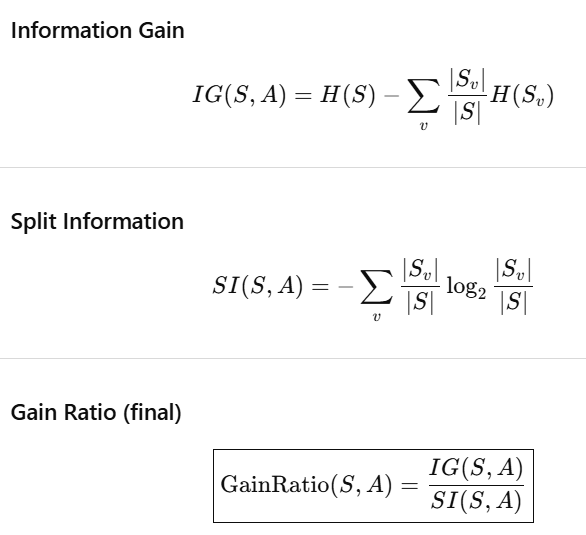

In [2136]:
def split_info(data,attribute):
    total_samples = len(data)
    si = 0.0

    for value in data[attribute].unique():
        subset_size = len(data[data[attribute] == value])
        prob = subset_size/total_samples

        if(prob>0):
            si -= prob*np.log2(prob)

    return si

In [2137]:
def gain_ratio(data,attribute,target_attribute):
    ig = information_gain(data,attribute,target_attribute)
    si = split_info(data,attribute)

    if si==0:
        return 0
    
    return ig/si

In [2138]:
def gain_ratio_all(data,attribute,target_attribute):
    gr_values = {}
    for j in attribute:
        gr_values[j] = gain_ratio(data,j,target_attribute)
    return gr_values

In [2139]:
gain_ratios = gain_ratio_all(
    car_data,
    all_attributes,
    target_car_attribute
)


Defining a function that chooses the impurity metric.

In [2140]:
def select_best_attribute(data, attributes, target, impurity_metric, cost_dict=None):
    scores = {}

    for attr in attributes:
        if impurity_metric == "entropy" or impurity_metric == "information_gain":
            scores[attr] = information_gain(data, attr, target)

        elif impurity_metric == "gini":
            scores[attr] = -gini_index(data, attr, target)

        elif impurity_metric == "gain_ratio":
            scores[attr] = gain_ratio(data, attr, target)

        elif impurity_metric == "cost_sensitive":
            scores[attr] = information_gain(data, attr, target) / cost_dict[attr]

        else:
            raise ValueError(f"Unknown impurity metric: {impurity_metric}")

    return max(scores, key=scores.get)


In [2141]:
def split_dataset(data,train_seg,val_seg, replace=False):
    train_ratio = train_seg/100
    val_ratio = val_seg/100
    n = len(data)
    if replace:
        train_data = data.sample(frac = train_ratio,replace=True)
        remaining = data
    else:
        train_data = data.sample(frac = train_ratio,replace=False)
        remaining = data.drop(train_data.index)

    val_data = remaining.sample(frac = val_ratio / (1-train_ratio),replace=replace)
    test_data = remaining.drop(val_data.index)

    return train_data,val_data,test_data

In [2142]:
def add_noise(data,attributes,percent_noise):
    noisy_data = data.copy()
    total_cells = len(data)*len(attributes)
    num_noisy = int((percent_noise)/100) * total_cells

    for _ in range(num_noisy):
        row = random.randit(0,len(data)-1)
        attr = random.choice(attributes)
        possible_values = data[attr].unique()
        noisy_data.at[data.index[row],attr] = random.cjoice(possible_values)

    return noisy_data

In [2143]:
def majority_class(data,target_attribute):
    return data[target_attribute].mode()[0]

Core tree builder

In [2144]:
def build_tree(
    data,
    attributes,
    target,
    depth=0,
    max_depth=None,
    max_impurity=None,
    impurity_metric="information_gain",
    cost_dict=None
):
    # -------------------------------
    # 1. Empty dataset
    # -------------------------------
    if len(data) == 0:
        return None

    # -------------------------------
    # 2. Pure node (MANDATORY)
    # -------------------------------
    if len(data[target].unique()) == 1:
        return data[target].iloc[0]

    # -------------------------------
    # 3. No attributes left
    # -------------------------------
    if len(attributes) == 0:
        return data[target].mode()[0]

    # -------------------------------
    # 4. Max depth stopping
    # -------------------------------
    if max_depth is not None and depth >= max_depth:
        return data[target].mode()[0]

    # -------------------------------
    # 5. Max impurity pruning (optional)
    # -------------------------------
    if max_impurity is not None:
        if impurity_metric in ["entropy", "information_gain", "gain_ratio"]:
            current_impurity = entropy(data, target)
        elif impurity_metric == "gini":
            current_impurity = gini_node(data, target)
        else:
            raise ValueError("Unknown impurity metric")

        if current_impurity <= max_impurity:
            return data[target].mode()[0]

    # -------------------------------
    # 6. Select best attribute
    # -------------------------------
    scores = {}

    for attr in attributes:
        if impurity_metric in ["entropy", "information_gain"]:
            scores[attr] = information_gain(data, attr, target)

        elif impurity_metric == "gini":
            scores[attr] = -gini_index(data, attr, target)

        elif impurity_metric == "gain_ratio":
            scores[attr] = gain_ratio(data, attr, target)

        elif impurity_metric == "cost_sensitive":
            scores[attr] = information_gain(data, attr, target) / cost_dict[attr]

        else:
            raise ValueError(f"Unknown impurity metric: {impurity_metric}")

    best_attr = max(sorted(scores), key=scores.get)

    # -------------------------------
    # 7. Create node
    # -------------------------------
    tree = {
        "_majority": data[target].mode()[0],
        best_attr: {}
    }

    remaining_attrs = [a for a in attributes if a != best_attr]

    # -------------------------------
    # 8. Recurse
    # -------------------------------
    for val in data[best_attr].unique():
        subset = data[data[best_attr] == val]
        tree[best_attr][val] = build_tree(
            subset,
            remaining_attrs,
            target,
            depth + 1,
            max_depth,
            max_impurity,
            impurity_metric,
            cost_dict
        )

    return tree


In [2145]:
def plot_impurity_reduction(
    data,
    attributes,
    target_attribute,
    impurity_metric,
    max_depth=None,
    max_impurity=0,
    cost_dict=None
):
    impurity_log = []

    total_samples = len(data)

    # -------------------------------
    # impurity function selector
    # -------------------------------
    def impurity_fn(subset):
        if impurity_metric == "gini":
            return gini_node(subset, target_attribute)
        else:  # entropy-based
            return entropy(subset, target_attribute)

    # -------------------------------
    # recursive tree builder with logging
    # -------------------------------
    def build_tree_with_logging(data, attributes, depth):
        # log impurity BEFORE split
        impurity_log.append(
            (len(data) / total_samples) * impurity_fn(data)
        )

        # stopping conditions
        if (
            len(data[target_attribute].unique()) == 1
            or len(attributes) == 0
            or (max_depth is not None and depth == max_depth)
            or impurity_fn(data) <= max_impurity
        ):
            return

        # select best attribute
        best_attr = select_best_attribute(
            data,
            attributes,
            target_attribute,
            impurity_metric,
            cost_dict
        )

        remaining_attrs = [a for a in attributes if a != best_attr]

        # split recursively
        for val in data[best_attr].unique():
            subset = data[data[best_attr] == val]
            build_tree_with_logging(subset, remaining_attrs, depth + 1)

    # -------------------------------
    # build tree and track impurity
    # -------------------------------
    build_tree_with_logging(data, attributes, depth=0)

    # -------------------------------
    # plot
    # -------------------------------
    plt.figure()
    plt.plot(range(len(impurity_log)), impurity_log, marker='o')
    plt.xlabel("Node Expansion Step")
    plt.ylabel("Total Impurity")
    plt.title("Gradual Reduction of Total Impurity During Tree Growth")
    plt.show()


In [2146]:
def decision_tree_to_rules(tree):
    rules = []

    def traverse(node, path):
        # ✅ LEAF NODE (must be FIRST)
        if not isinstance(node, dict):
            rules.append(" AND ".join(path) + f" => {node}")
            return

        # ✅ INTERNAL NODE
        attribute = next(k for k in node if k != "_majority")

        for value, child in node[attribute].items():
            traverse(child, path + [f"({attribute} = {value})"])

    traverse(tree, [])
    return " OR\n".join(rules)


In [2147]:
def predict(tree, sample):
    if not isinstance(tree, dict):
        return tree

    attribute = next(k for k in tree if k != "_majority")
    value = sample[attribute]

    if value not in tree[attribute]:
        return tree["_majority"]

    return predict(tree[attribute][value], sample)


In [2148]:
def accuracy(tree, data, target):
    if len(data) == 0:
        return 0

    correct = 0
    for _, row in data.iterrows():
        if predict(tree, row) == row[target]:
            correct += 1

    return correct / len(data)


In [2149]:
def plot_accuracy_vs_branching(
    train_data,
    val_data,
    test_data,
    all_attributes,
    target_attribute,
    impurity_metric,
    max_impurity=0,
    cost_dict=None
):
    train_accs = []
    val_accs = []
    test_accs = []

    # Maximum meaningful depth = number of attributes
    max_depth = len(all_attributes)
    effective_max_depth = max_depth if max_depth is not None else  1e9
    for depth in range(0, effective_max_depth + 1):
        # Build tree with current depth limit
        tree = build_tree(
            data=train_data,
            attributes=all_attributes,
            target=target_attribute,
            depth=0,
            max_depth=depth,
            max_impurity=max_impurity,
            impurity_metric=impurity_metric,
            cost_dict=cost_dict
        )

        # Compute accuracies
        train_accs.append(accuracy(tree, train_data, target_attribute))
        val_accs.append(accuracy(tree, val_data, target_attribute))
        test_accs.append(accuracy(tree, test_data, target_attribute))

    # Plot curves
    plt.figure()
    plt.plot(range(len(train_accs)), train_accs, label="Training")
    plt.plot(range(len(val_accs)), val_accs, label="Validation")
    plt.plot(range(len(test_accs)), test_accs, label="Testing")
    plt.xlabel("Number of Expanded Levels (Tree Depth)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Progressive Node Expansion")
    plt.legend()
    plt.show()


In [2150]:
def tree_depth(tree):
    # Leaf node
    if not isinstance(tree, dict):
        return 0

    # Internal node
    attribute = next(k for k in tree if k != "_majority")
    return 1 + max(tree_depth(child) for child in tree[attribute].values())


# Doing it for Setting - 0

In [2151]:
train_seg_0 = 80
val_seg_0 = 10
impurity_metric_0 = 'information_gain'
train_data_0 , val_data_0 ,test_data_0 = split_dataset(car_data,train_seg_0,val_seg_0)

In [2152]:
tree_0 = build_tree(
    train_data_0,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='information_gain'
)

In [2153]:
print(tree_depth(tree_0))

6


In [2154]:
train_acc_0 = accuracy(tree_0, train_data_0, target_car_attribute)
val_acc_0   = accuracy(tree_0, val_data_0, target_car_attribute)
test_acc_0  = accuracy(tree_0, test_data_0, target_car_attribute)

print("Train_acc:",train_acc_0)
print("Val_acc:",val_acc_0)
print("Test_acc:",test_acc_0)

Train_acc: 1.0
Val_acc: 0.953757225433526
Test_acc: 0.9364161849710982


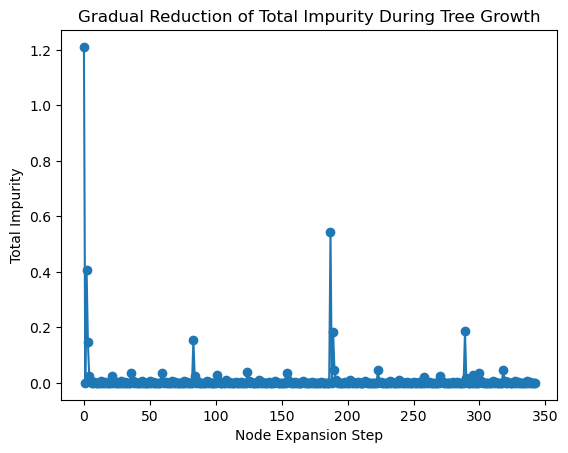

In [2155]:
plot_impurity_reduction(
    train_data_0,
    all_attributes,
    target_car_attribute,
    impurity_metric_0,
    max_depth=None,
    max_impurity=0
)

In [2156]:
print(decision_tree_to_rules(tree_0))

(safety = low) => unacc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = low) AND (lug_boot = small) => unacc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = low) AND (lug_boot = big) => acc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = low) AND (lug_boot = med) AND (doors = 5more) => acc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = low) AND (lug_boot = med) AND (doors = 2) => unacc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = low) AND (lug_boot = med) AND (doors = 4) => acc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = high) => unacc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = med) AND (lug_boot = small) => unacc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = med) AND (lug_boot = big) => acc OR
(safety = med) AND (persons = 4) AND (buying = vhigh) AND (maint = med) AND (lug_boot = med) AND (doors =

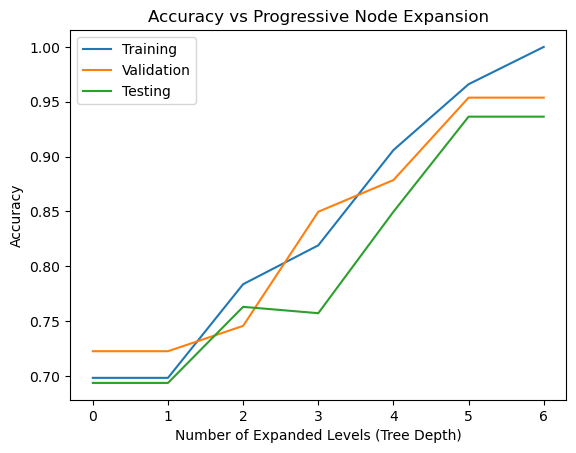

In [2157]:
plot_accuracy_vs_branching(
    train_data_0,
    val_data_0,
    test_data_0,
    all_attributes,
    target_car_attribute,
    impurity_metric_0,
    max_impurity=0,
    cost_dict=None
)

## Doing it for Setting-1

In [2158]:
train_seg_1 = 60
val_seg_1 = 20
impurity_metric_1 = 'information_gain'
train_data_1 , val_data_1 ,test_data_1 = split_dataset(car_data,train_seg_1,val_seg_1)

In [2159]:
tree_1 = build_tree(
    train_data_1,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='information_gain'
)

In [2160]:
print(tree_depth(tree_1))

6


In [2161]:
train_acc_1 = accuracy(tree_1, train_data_1, target_car_attribute)
val_acc_1   = accuracy(tree_1, val_data_1, target_car_attribute)
test_acc_1  = accuracy(tree_1, test_data_1, target_car_attribute)

print("Train_acc:",train_acc_1)
print("Val_acc:",val_acc_1)
print("Test_acc:",test_acc_1)

Train_acc: 1.0
Val_acc: 0.9219653179190751
Test_acc: 0.8869565217391304


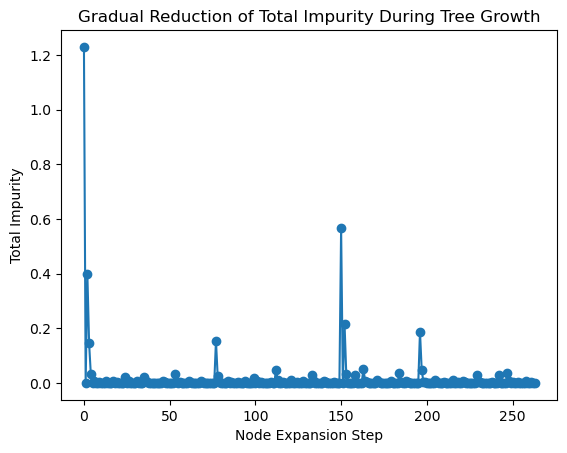

In [2162]:
plot_impurity_reduction(
    train_data_1,
    all_attributes,
    target_car_attribute,
    impurity_metric_1,
    max_depth=None,
    max_impurity=0
)

In [2163]:
print(decision_tree_to_rules(tree_1))

(safety = low) => unacc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = high) => acc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = vhigh) AND (lug_boot = small) => unacc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = vhigh) AND (lug_boot = big) => acc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = vhigh) AND (lug_boot = med) AND (doors = 4) => acc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = vhigh) AND (lug_boot = med) AND (doors = 5more) => acc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = vhigh) AND (lug_boot = med) AND (doors = 3) => unacc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = med) => good OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = small) => acc OR
(safety = med) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = big) => good OR
(safety = me

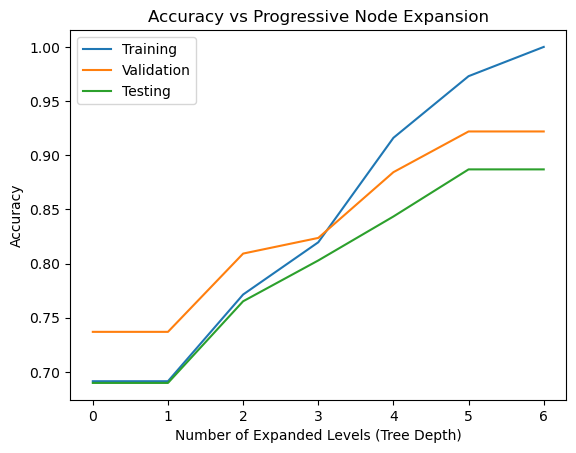

In [2164]:
plot_accuracy_vs_branching(
    train_data_1,
    val_data_1,
    test_data_1,
    all_attributes,
    target_car_attribute,
    impurity_metric_1,
    max_impurity=0,
    cost_dict=None
)

## Doing it for Setting-2

In [2165]:
train_seg_2 = 80
val_seg_2 = 10
percent_noise_2=10
impurity_metric_2 = 'information_gain'
train_data_2 , val_data_2 ,test_data_2 = split_dataset(car_data,train_seg_2,val_seg_2)

In [2166]:
train_data_2=add_noise(train_data_2,all_attributes,percent_noise_2)

In [2167]:
tree_2 = build_tree(
    train_data_2,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='information_gain'
)

In [2168]:
print(tree_depth(tree_2))

6


6


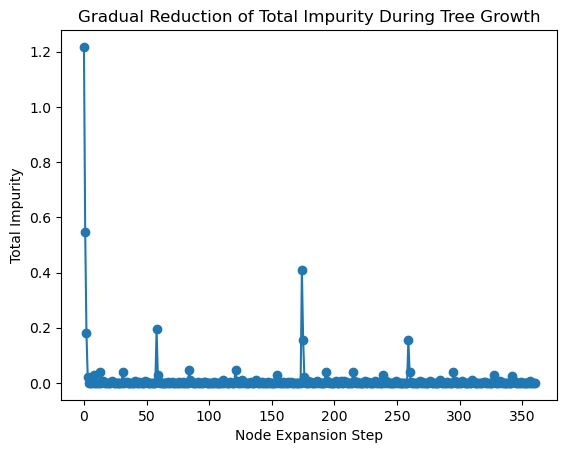

(safety = high) AND (persons = 4) AND (buying = high) AND (maint = med) => acc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = vhigh) => unacc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = high) => acc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = low) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = med) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = low) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = high) => unacc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = vhigh) => unacc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = vhigh) => acc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = med) AND (lug_boot = med) AND (doors = 3) => acc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = med) AND (lug_boot = med) AND (doors = 5more) => vgood OR
(sa

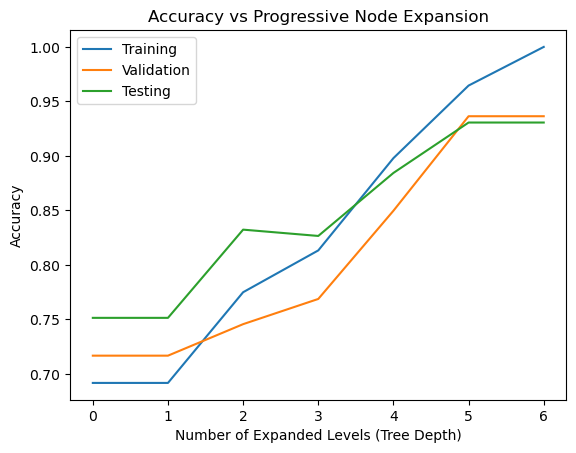

In [2169]:
train_seg_2 = 80
val_seg_2 = 10
percent_noise_2=10
impurity_metric_2 = 'information_gain'
train_data_2 , val_data_2 ,test_data_2 = split_dataset(car_data,train_seg_2,val_seg_2)


train_data_2=add_noise(train_data_2,all_attributes,percent_noise_2)

tree_2 = build_tree(
    train_data_2,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='information_gain'
)

print(tree_depth(tree_2))

plot_impurity_reduction(
    train_data_2,
    all_attributes,
    target_car_attribute,
    impurity_metric_2,
    max_depth=None,
    max_impurity=0
)

print(decision_tree_to_rules(tree_2))

train_acc_2 = accuracy(tree_2, train_data_2, target_car_attribute)
val_acc_2  = accuracy(tree_2, val_data_2, target_car_attribute)
test_acc_2 = accuracy(tree_2, test_data_2, target_car_attribute)

print("Train_acc:",train_acc_2)
print("Val_acc:",val_acc_2)
print("Test_acc:",test_acc_2)

plot_accuracy_vs_branching(
    train_data_2,
    val_data_2,
    test_data_2,
    all_attributes,
    target_car_attribute,
    impurity_metric_2,
    max_impurity=0,
    cost_dict=None
)

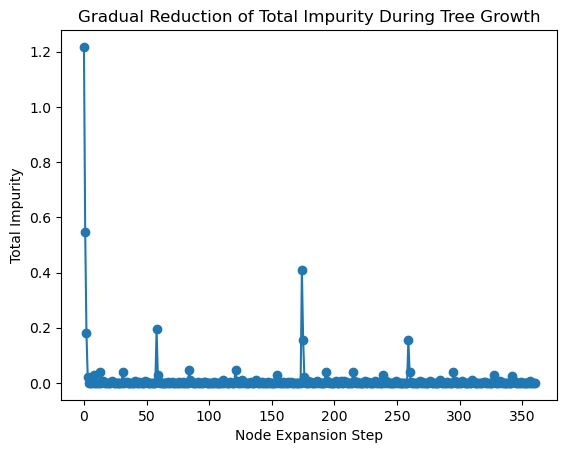

In [2170]:
plot_impurity_reduction(
    train_data_2,
    all_attributes,
    target_car_attribute,
    impurity_metric_2,
    max_depth=None,
    max_impurity=0
)

In [2171]:
print(decision_tree_to_rules(tree_2))

(safety = high) AND (persons = 4) AND (buying = high) AND (maint = med) => acc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = vhigh) => unacc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = high) => acc OR
(safety = high) AND (persons = 4) AND (buying = high) AND (maint = low) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = med) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = low) => acc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = high) => unacc OR
(safety = high) AND (persons = 4) AND (buying = vhigh) AND (maint = vhigh) => unacc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = vhigh) => acc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = med) AND (lug_boot = med) AND (doors = 3) => acc OR
(safety = high) AND (persons = 4) AND (buying = med) AND (maint = med) AND (lug_boot = med) AND (doors = 5more) => vgood OR
(sa

In [2172]:
train_acc_2 = accuracy(tree_2, train_data_2, target_car_attribute)
val_acc_2  = accuracy(tree_2, val_data_2, target_car_attribute)
test_acc_2 = accuracy(tree_2, test_data_2, target_car_attribute)

print("Train_acc:",train_acc_2)
print("Val_acc:",val_acc_2)
print("Test_acc:",test_acc_2)

Train_acc: 1.0
Val_acc: 0.9364161849710982
Test_acc: 0.930635838150289


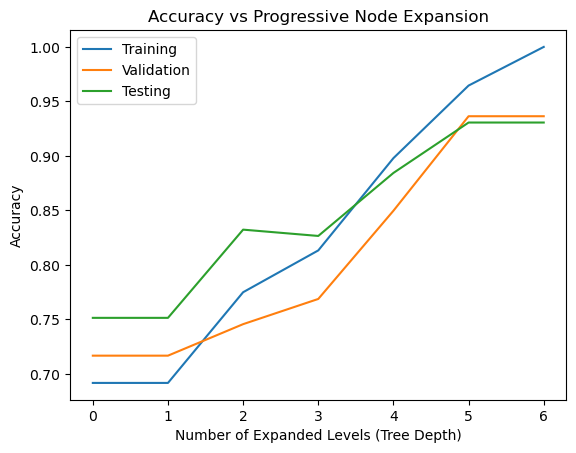

In [2173]:
plot_accuracy_vs_branching(
    train_data_2,
    val_data_2,
    test_data_2,
    all_attributes,
    target_car_attribute,
    impurity_metric_2,
    max_impurity=0,
    cost_dict=None
)

## Doing it for Setting - 3

In [2174]:
train_seg_3 = 60
val_seg_3 = 20
impurity_metric_3 = 'information_gain'
percent_noise_3 = 10
train_data_3 , val_data_3 ,test_data_3 = split_dataset(car_data,train_seg_3,val_seg_3)

In [2175]:
train_data_3 = add_noise(train_data_3,all_attributes,percent_noise_3)

In [2176]:
tree_3 = build_tree(
    train_data_3,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='information_gain'
)

In [2177]:
print(tree_depth(tree_3))

6


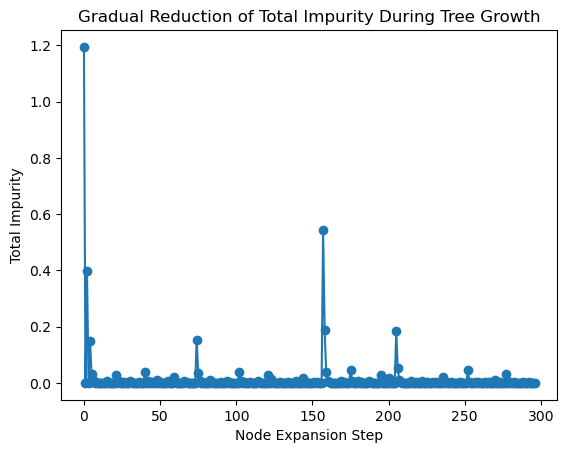

In [2178]:
plot_impurity_reduction(
    train_data_3,
    all_attributes,
    target_car_attribute,
    impurity_metric_3,
    max_depth=None,
    max_impurity=0
)

In [2179]:
print(decision_tree_to_rules(tree_3))

(safety = low) => unacc OR
(safety = med) AND (persons = 2) => unacc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 2) => unacc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 5more) AND (maint = med) => acc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 5more) AND (maint = high) => acc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 5more) AND (maint = vhigh) => unacc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 5more) AND (maint = low) => acc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 4) => acc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = med) AND (doors = 3) => unacc OR
(safety = med) AND (persons = 4) AND (buying = high) AND (lug_boot = big) AND (maint = low) => acc OR
(safety = med) AND (persons =

In [2180]:
train_acc_3 = accuracy(tree_3, train_data_3, target_car_attribute)
val_acc_3  = accuracy(tree_3, val_data_3, target_car_attribute)
test_acc_3 = accuracy(tree_3, test_data_3, target_car_attribute)

print("Train_acc:",train_acc_3)
print("Val_acc:",val_acc_3)
print("Test_acc:",test_acc_3)

Train_acc: 1.0
Val_acc: 0.8930635838150289
Test_acc: 0.9304347826086956


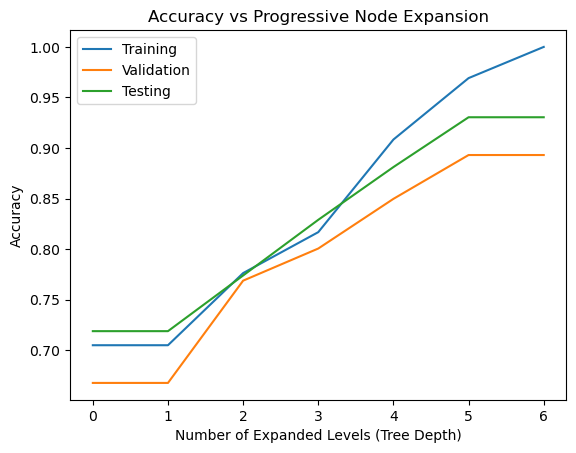

In [2181]:
plot_accuracy_vs_branching(
    train_data_3,
    val_data_3,
    test_data_3,
    all_attributes,
    target_car_attribute,
    impurity_metric_3,
    max_impurity=0,
    cost_dict=None
)

## Doing it for Setting - 4 

In [2182]:
train_seg_4 = 80
val_seg_4 = 10
impurity_metric_4 = 'information_gain'
train_data_4 , val_data_4 ,test_data_4 = split_dataset(car_data,train_seg_4,val_seg_4)

In [2183]:
tree_4 = build_tree(
    train_data_4,
    all_attributes,
    target_car_attribute,
    max_depth=3,
    max_impurity=0.25,
    impurity_metric='information_gain'
)

In [2184]:
print(tree_depth(tree_4))

3


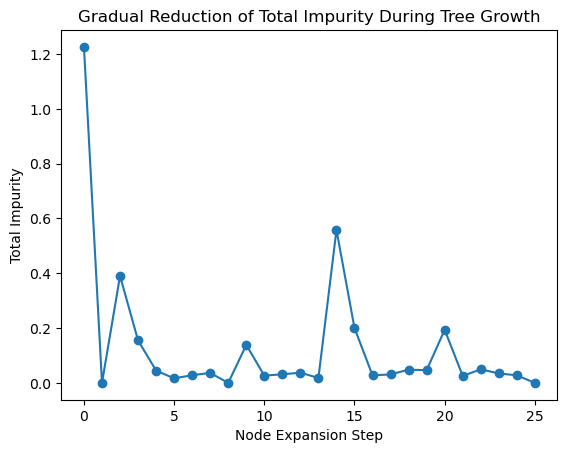

In [2185]:
plot_impurity_reduction(
    train_data_4,
    all_attributes,
    target_car_attribute,
    impurity_metric_4,
    max_depth=3,
    max_impurity=0.25
)

In [2186]:
print(decision_tree_to_rules(tree_4))

(safety = low) => unacc OR
(safety = med) AND (persons = more) AND (maint = low) => acc OR
(safety = med) AND (persons = more) AND (maint = vhigh) => unacc OR
(safety = med) AND (persons = more) AND (maint = high) => acc OR
(safety = med) AND (persons = more) AND (maint = med) => acc OR
(safety = med) AND (persons = 2) => unacc OR
(safety = med) AND (persons = 4) AND (maint = high) => unacc OR
(safety = med) AND (persons = 4) AND (maint = med) => acc OR
(safety = med) AND (persons = 4) AND (maint = low) => acc OR
(safety = med) AND (persons = 4) AND (maint = vhigh) => unacc OR
(safety = high) AND (persons = more) AND (buying = high) => acc OR
(safety = high) AND (persons = more) AND (buying = vhigh) => unacc OR
(safety = high) AND (persons = more) AND (buying = med) => acc OR
(safety = high) AND (persons = more) AND (buying = low) => vgood OR
(safety = high) AND (persons = 4) AND (buying = high) => acc OR
(safety = high) AND (persons = 4) AND (buying = low) => vgood OR
(safety = high) 

In [2187]:
train_acc_4 = accuracy(tree_4, train_data_4, target_car_attribute)
val_acc_4 = accuracy(tree_4, val_data_4, target_car_attribute)
test_acc_4 = accuracy(tree_4, test_data_4, target_car_attribute)

print("Train_acc:",train_acc_4)
print("Val_acc:",val_acc_4)
print("Test_acc:",test_acc_4)

Train_acc: 0.8133140376266281
Val_acc: 0.791907514450867
Test_acc: 0.791907514450867


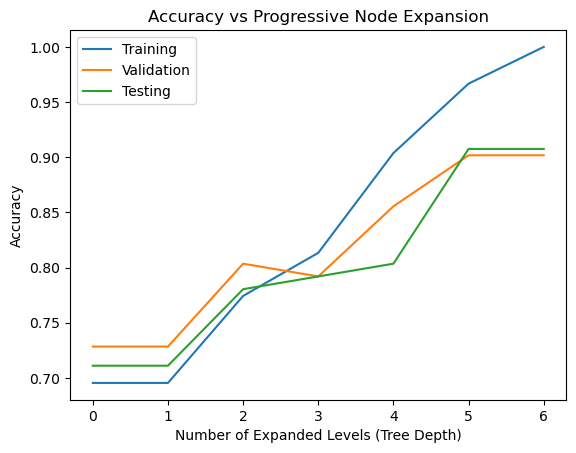

In [2188]:
plot_accuracy_vs_branching(
    train_data_4,
    val_data_4,
    test_data_4,
    all_attributes,
    target_car_attribute,
    impurity_metric_4,
    max_impurity=0,
    cost_dict=None
)

## Doing it for Setting - 5

In [2189]:
train_seg_5 = 60
val_seg_5 = 20
impurity_metric_5 = 'gini'
train_data_5 , val_data_5 ,test_data_5 = split_dataset(car_data,train_seg_5,val_seg_5)

In [2190]:
tree_5 = build_tree(
    train_data_5,
    all_attributes,
    target_car_attribute,
    max_depth=None,
    max_impurity=0,
    impurity_metric='gini'
)

In [2191]:
print(tree_depth(tree_5))

6


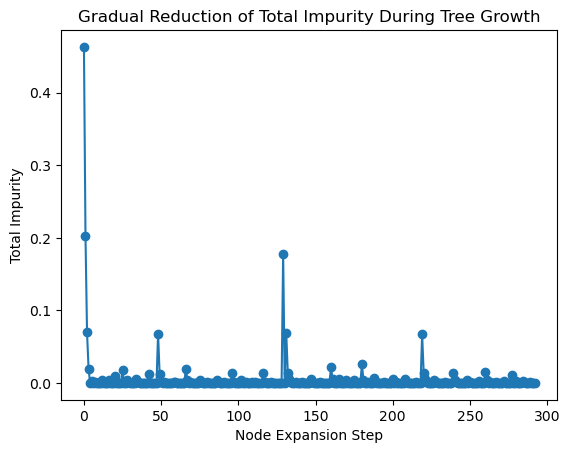

In [2192]:
plot_impurity_reduction(
    train_data_5,
    all_attributes,
    target_car_attribute,
    impurity_metric_5,
    max_depth=None,
    max_impurity=0
)

In [2193]:
print(decision_tree_to_rules(tree_5))

(safety = high) AND (persons = 4) AND (buying = low) AND (maint = vhigh) => acc OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = low) AND (lug_boot = big) => vgood OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = low) AND (lug_boot = med) AND (doors = 2) => good OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = low) AND (lug_boot = med) AND (doors = 3) => good OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = low) AND (lug_boot = med) AND (doors = 5more) => vgood OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = low) AND (lug_boot = small) => good OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = small) => good OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = med) => good OR
(safety = high) AND (persons = 4) AND (buying = low) AND (maint = med) AND (lug_boot = big) => vgood OR
(safety = high) AND (persons = 4) 

In [2194]:
train_acc_5 = accuracy(tree_5, train_data_5, target_car_attribute)
val_acc_5 = accuracy(tree_5, val_data_5, target_car_attribute)
test_acc_5 = accuracy(tree_5, test_data_5, target_car_attribute)

print("Train_acc:",train_acc_5)
print("Val_acc:",val_acc_5)
print("Test_acc:",test_acc_5)

Train_acc: 1.0
Val_acc: 0.930635838150289
Test_acc: 0.9478260869565217


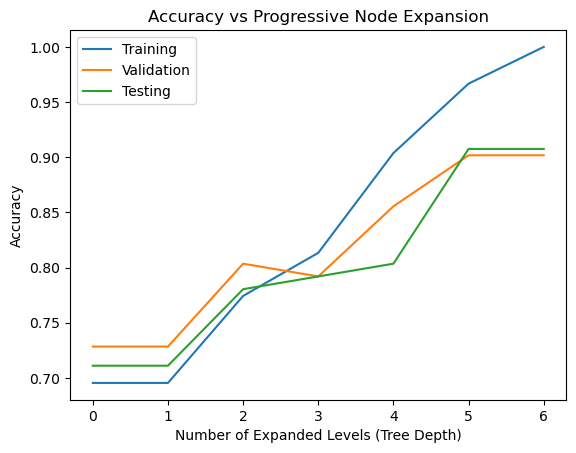

In [2195]:
plot_accuracy_vs_branching(
    train_data_4,
    val_data_4,
    test_data_4,
    all_attributes,
    target_car_attribute,
    impurity_metric_4,
    max_impurity=0,
    cost_dict=None
)